In [ ]:
import random
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS

In [ ]:
# Get S&P 500 tickers 
def get_sp500_tickers(sample_size=300):
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    table = pd.read_html(url)[0]    
    tickers = table['Symbol'].tolist()
    sample_tickers = random.sample(tickers, sample_size)
    return sample_tickers

In [3]:
# Fetch historical data
def get_historical_data(tickers):
    data = pd.DataFrame()
    for i in tickers:
        stock_data = yf.download(i, start="2022-09-30", end="2024-09-30")
        data[i] = stock_data['Adj Close']
    return data

In [4]:
# Perform the ADF test for stationarity
def adf_test(series):         
    result = adfuller(series)
    return result[1]  # Return p-value

In [5]:
# Calculate z-score for the residuals
def calculate_zscore(residuals):
    mean = residuals.rolling(window=50).mean()
    std = residuals.rolling(window=50).std()
    zscore = (residuals - mean) / std
    return zscore

In [6]:
# Function to calculate half-life based on residuals
def calculate_half_life(residuals):
    residuals_lag = residuals.shift(1).dropna()
    delta_residuals = (residuals - residuals_lag).dropna()
    
    # Regress delta_residuals on residuals_lag to estimate half-life
    regression = OLS(delta_residuals, residuals_lag).fit() # fit() method is called on this object for fitting the regression line to the data.
    half_life = -np.log(2) / regression.params[0] # -ln(2)/slope of the regression
    
    return half_life

In [7]:
def get_start_dates(data):
    start_dates = {}
    for ticker in data.columns:
        start_date = data[ticker].first_valid_index()  # Get the first valid index (date)
        if start_date is not None:
            start_dates[ticker] = start_date.strftime('%Y-%m-%d')  # Convert to string format
        else:
            start_dates[ticker] = None  # Handle cases with no valid dates
    return start_dates

In [8]:
# %% Cointegration test between pairs of stocks with ADF and half-life calculation
def cointegration_test(data, start_dates):
    pairs = []
    results = []
    residuals_dict = {}

    tickers = data.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            # Check if the first three letters of the stock tickers are the same
            if tickers[i][:3] == tickers[j][:3]:
                continue  # Skip this pair

            x = data[tickers[i]].dropna()
            y = data[tickers[j]].dropna()

            # Align x and y by matching labels (dates)
            x, y = x.align(y, join='inner')

            # Check if start dates are the same
            if start_dates[tickers[i]] != start_dates[tickers[j]]:
                continue  # Disconsider this pair if start dates are not the same

            # Skip to the next pair if x and y do not have the same size
            if len(x) != len(y) or x.empty or y.empty:
                continue

            try:
                # Perform the cointegration test
                score, p_value, _ = coint(x, y)
            except ValueError:
                continue

            if p_value < 0.05:  # Cointegration threshold
                # Ratio between the two prices
                ratio = x / y
                adf_p_value = adf_test(ratio)

                if adf_p_value < 0.05:  # ADF stationarity threshold
                    # Store the residuals from the OLS regression
                    ols_result = OLS(x, y).fit()
                    residuals = ols_result.resid

                    # Calculate half-life based on residuals
                    half_life = calculate_half_life(residuals)

                    pairs.append((tickers[i], tickers[j]))
                    results.append((tickers[i], tickers[j], score, p_value, adf_p_value, half_life))
                    residuals_dict[(tickers[i], tickers[j])] = residuals

    results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'Cointegration Score', 'Cointegration p-value', 'ADF p-value', 'Half-life'])
    return results_df, residuals_dict

In [9]:
# %% Get S&P 500 tickers and historical data
ticks = get_sp500_tickers()
historical_data = get_historical_data(ticks)

# Get start dates for each stock
start_dates = get_start_dates(historical_data)

# Cointegration test
results_df, residuals_dict = cointegration_test(historical_data, start_dates)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [55]:
# Filter pairs based on cointegration first
cointegrated_pairs = results_df[results_df['Cointegration p-value'] < 0.05]

# Among cointegrated pairs, apply ADF test and half-life ranking
adf_filtered_results = cointegrated_pairs[cointegrated_pairs['ADF p-value'] < 0.05]

# Sort by half-life to prioritize pairs with faster mean reversion
sorted_results = adf_filtered_results.sort_values(by='Half-life', ascending=True)

# Take top 5 cointegrated pairs
top_20_pairs = sorted_results.iloc[:20]

print(len(ticks))
print("historical_data:", historical_data.head())
print("results_df:", results_df.head())
print("cointegrated_pairs:", cointegrated_pairs.head())
print("adf_filtered_results", adf_filtered_results.head())
print("sorted_results", adf_filtered_results.head())

500
historical_data:                  CSGP  PLTR        CZR        FRT        OKE       CINF  \
Date                                                                      
2022-09-30  69.650002  8.13  32.259998  82.734009  45.826752  84.762642   
2022-10-03  71.989998  8.24  34.150002  83.624496  47.892708  88.254585   
2022-10-04  73.769997  8.46  38.049999  85.882889  50.370075  91.027344   
2022-10-05  74.400002  8.42  38.520000  85.433044  50.548939  91.453178   
2022-10-06  75.209999  8.47  38.619999  84.404846  49.752968  90.440605   

                   NI         PPG       ROST        TJX  ...        DAL  \
Date                                                     ...              
2022-09-30  23.382677  106.414742  82.447525  60.268810  ...  27.707195   
2022-10-03  24.143845  109.779572  84.100983  61.025566  ...  27.904686   
2022-10-04  24.969994  114.547981  87.447006  63.470467  ...  30.363377   
2022-10-05  24.283083  115.586288  87.877510  63.839146  ...  30.136269   
202

In [56]:
# %% Define backtest using z-score signals
def backtest_zscore_strategy(stock1_prices, stock2_prices, zscore_residuals):
    positions = []
    returns = []

    position = None
    entry_stock1_price = None
    entry_stock2_price = None

    for i in range(len(zscore_residuals)):
        # Exit long position when z-score goes above 0 (mean reversion)
        if position == 'long' and zscore_residuals.iloc[i] >= 0:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the long position
            long_return = (exit_stock1_price - entry_stock1_price) / entry_stock1_price
            short_return = (entry_stock2_price - exit_stock2_price) / entry_stock2_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Exit short position when z-score goes below 0 (mean reversion)
        elif position == 'short' and zscore_residuals.iloc[i] <= 0:
            exit_stock1_price = stock1_prices.iloc[i]
            exit_stock2_price = stock2_prices.iloc[i]

            # Calculate return for the short position
            long_return = (exit_stock2_price - entry_stock2_price) / entry_stock2_price
            short_return = (entry_stock1_price - exit_stock1_price) / entry_stock1_price
            returns.append(long_return + short_return)
            positions.append(('exit', i))

            position = None  # Exit the position
            continue  # Skip to the next iteration after exiting

        # Enter long position when z-score drops below -1
        if position is None and zscore_residuals.iloc[i] <= -1.:
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'long'
            positions.append(('long', i))

        # Enter short position when z-score rises above 1
        elif position is None and zscore_residuals.iloc[i] >= 1:
            entry_stock1_price = stock1_prices.iloc[i]
            entry_stock2_price = stock2_prices.iloc[i]
            position = 'short'
            positions.append(('short', i))

    return positions, returns

In [61]:
# Initialize dictionaries to store results for top 3 pairs
overall_returns = {}
sharpe_ratios = {}
all_positions = {}
total_sum_of_returns = 0  # Initialize a variable to accumulate total returns
returns_arrays = []  # Initialize a list to store returns from all pairs

# Iterate through each pair in the top 5 pairs
for idx, row in top_20_pairs.iterrows():
    stock1, stock2 = row['Stock 1'], row['Stock 2']

    # Get residuals for the pair
    residuals = residuals_dict[(stock1, stock2)]
    
    # Calculate z-score of residuals
    zscore = calculate_zscore(residuals)

    stock1_prices = historical_data[stock1]
    stock2_prices = historical_data[stock2]

    # Backtest strategy for this pair
    positions, returns = backtest_zscore_strategy(stock1_prices, stock2_prices, zscore)
    
    # Store the positions and returns for each pair
    overall_returns[(stock1, stock2)] = returns
    all_positions[(stock1, stock2)] = positions

    # Calculate returns for the current pair
    sum_of_returns = np.sum(returns)
    total_sum_of_returns += sum_of_returns  # Accumulate the total sum of returns

    # Append the returns to returns_arrays for the total Sharpe ratio calculation
    returns_arrays.extend(returns)

    # Calculating risk-free rate
    risk_free_rate = 0.02  # Assuming a 2% annual risk-free rate
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / 252) - 1  # Adjusted for daily returns

    # Convert returns to a NumPy array
    returns_array = np.array(returns)

    # Excess returns (returns - daily risk-free rate)
    excess_returns = returns_array - daily_risk_free_rate

    # Mean of excess returns
    mean_excess_return = excess_returns.mean()

    # Standard deviation of returns (volatility)
    volatility = returns_array.std()

    sharpe_ratio = mean_excess_return / volatility
    sharpe_ratios[(stock1, stock2)] = sharpe_ratio

# Print results for each pair
for pair in top_20_pairs.itertuples():
    pair_key = (pair[1], pair[2])
    returns = overall_returns[pair_key]
    sum_of_returns = np.sum(returns)

    print(f"Pair: {pair[1]} and {pair[2]}")
    print(f"Returns: {returns}")
    print(f"Sum of Returns: {sum_of_returns}")
    print(f"Sharpe Ratio: {sharpe_ratios[pair_key]}")
    print(f"Positions: {all_positions[pair_key]}")
    print()

# Print the total sum of returns for all pairs
print(f"Total Return: {total_sum_of_returns}%")

# Calculate the Sharpe Ratio of the strategy
returns_array_total = np.array(returns_arrays)
excess_returns_total = returns_array_total - daily_risk_free_rate

mean_excess_return_total = excess_returns_total.mean()

volatility_total = returns_array_total.std()

overall_sharpe_ratio = mean_excess_return_total / volatility_total

print(f"Sharpe Ratio for the Strategy: {overall_sharpe_ratio}")

Pair: FE and CMS
Returns: [np.float64(0.025338560253221495), np.float64(0.029216375794363057), np.float64(0.02302772161002336), np.float64(0.016144856807794705), np.float64(0.020306048986004514), np.float64(0.02552536123348196), np.float64(0.016373154416766764), np.float64(0.015599214693744479), np.float64(0.003195723560641156), np.float64(0.03264227891421616), np.float64(0.02002734819893634), np.float64(0.007267772999147354), np.float64(0.02307908578516195), np.float64(0.013660929783565371), np.float64(0.03408275181840198), np.float64(0.032209804453023815), np.float64(0.02288093656962191), np.float64(0.013143535597826739), np.float64(0.024534443133592106), np.float64(0.011095642161114257), np.float64(0.01993177582070161), np.float64(0.020637560330860026), np.float64(0.014993765026009354), np.float64(0.01314243634547026), np.float64(0.01055166188224339), np.float64(0.00860096439299142), np.float64(0.01163295093201694)]
Sum of Returns: 0.5088426615009425
Sharpe Ratio: 2.377138373921474


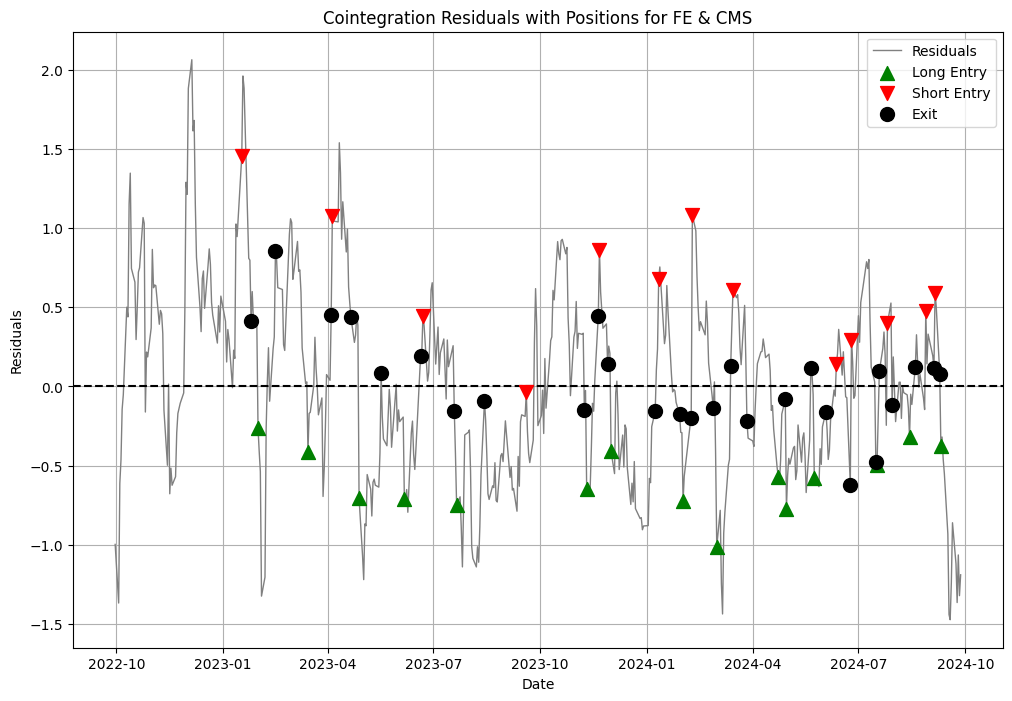

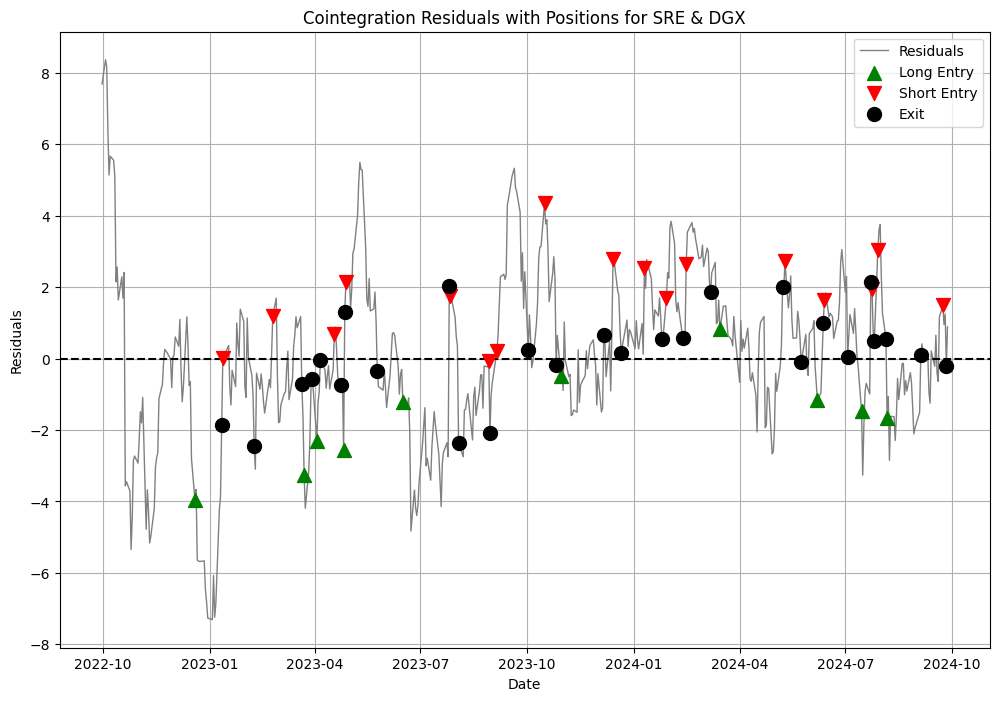

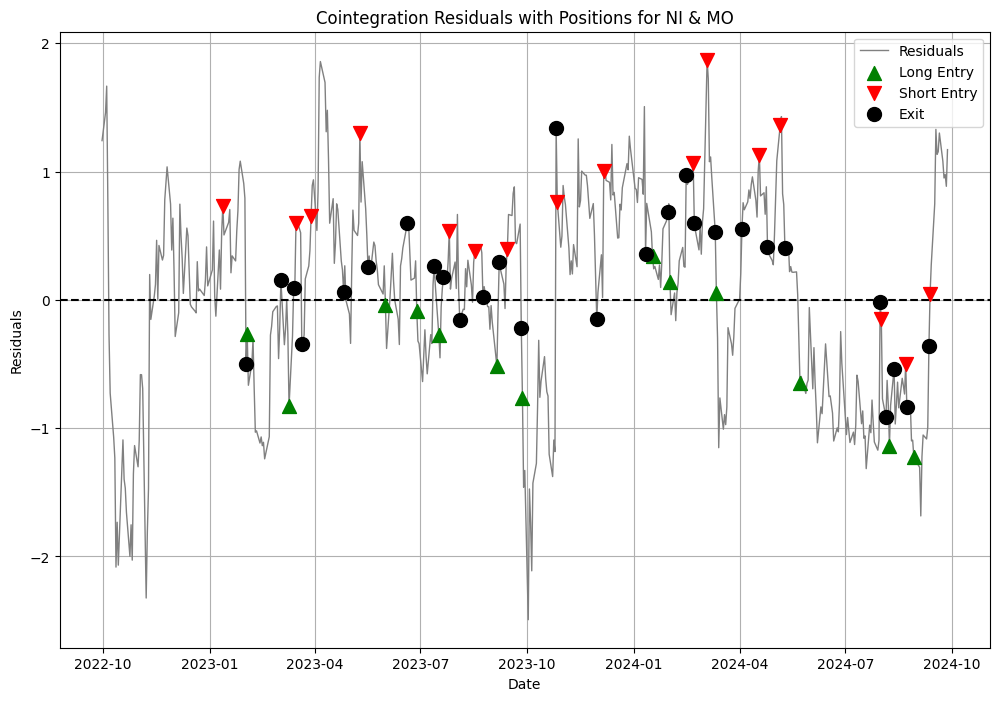

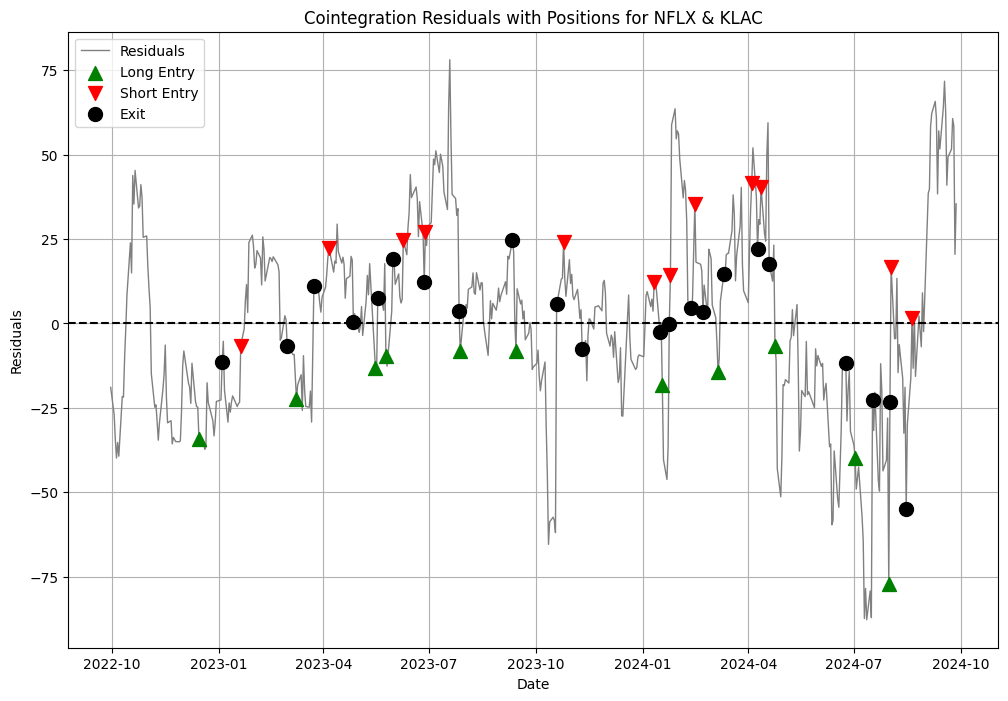

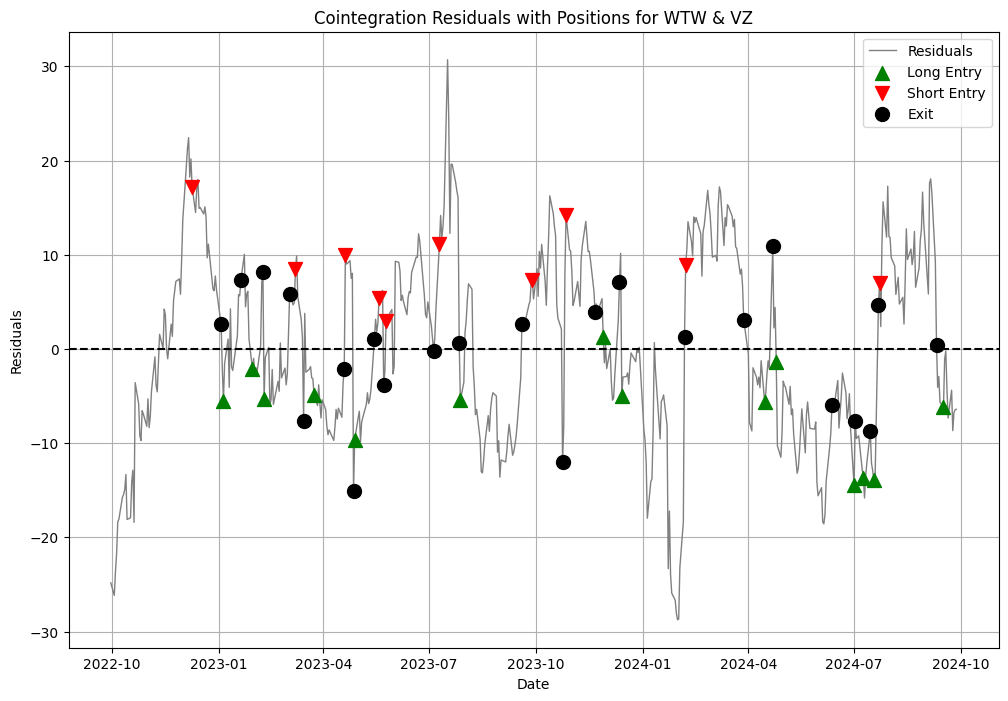

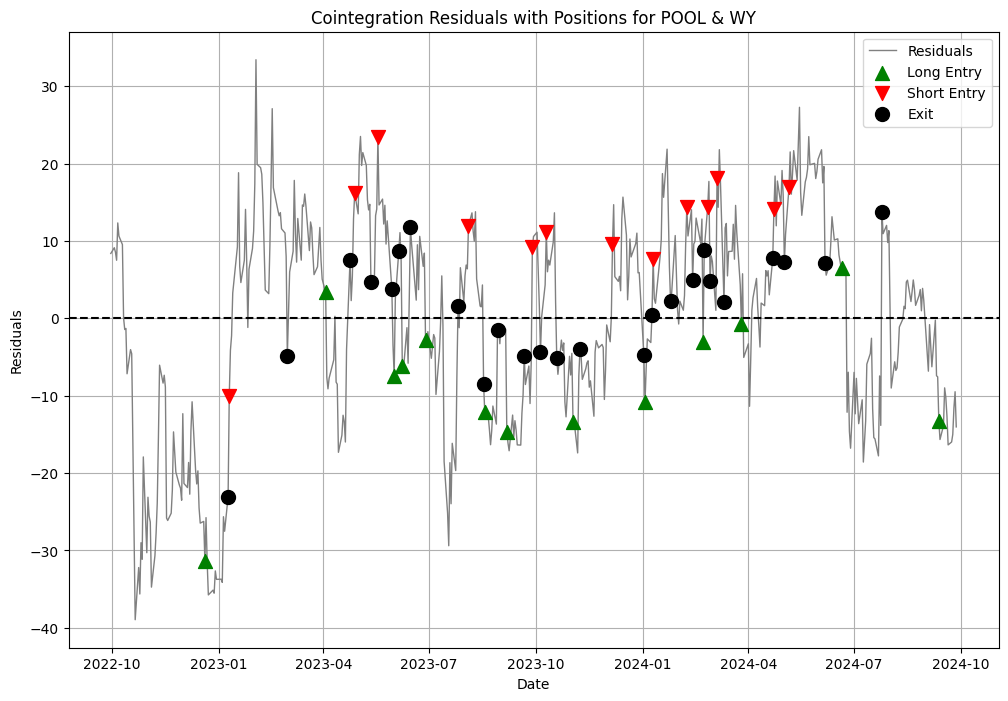

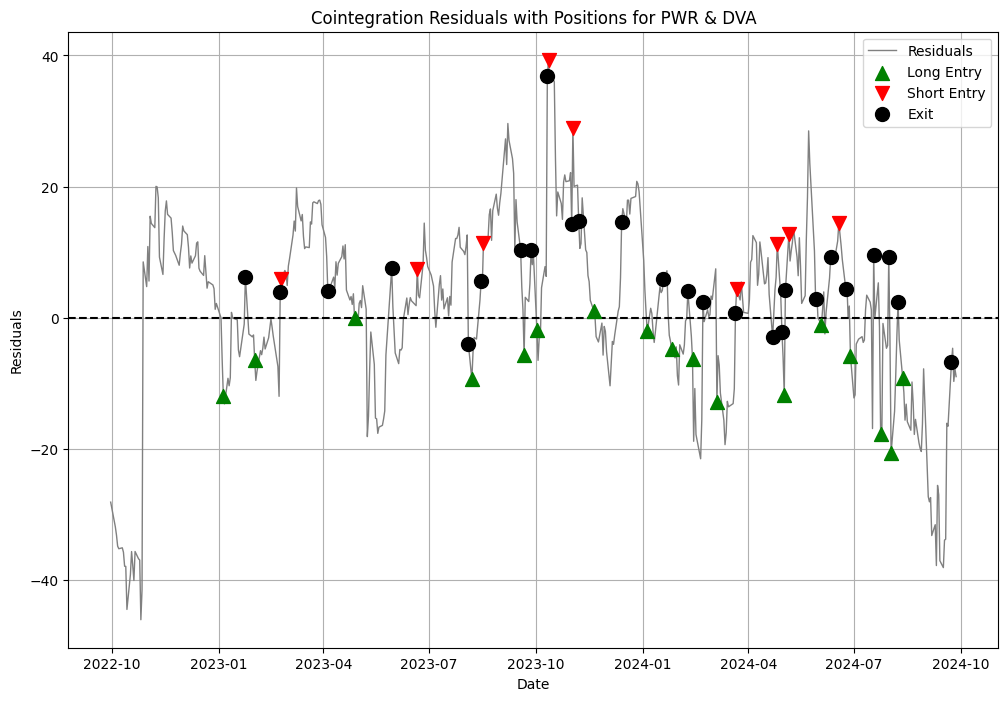

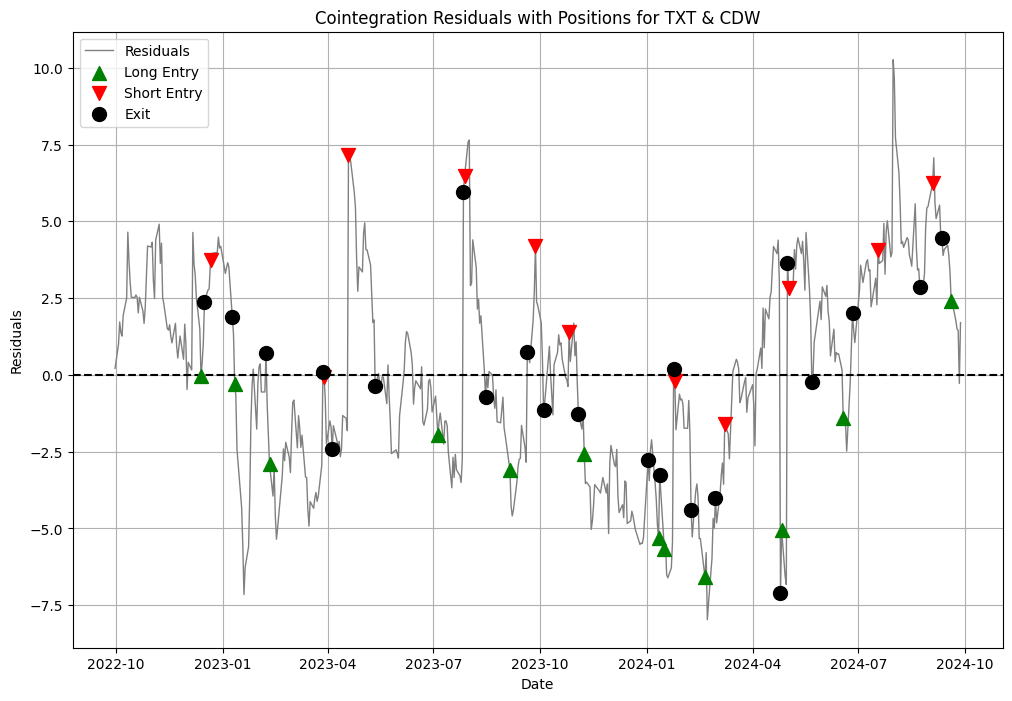

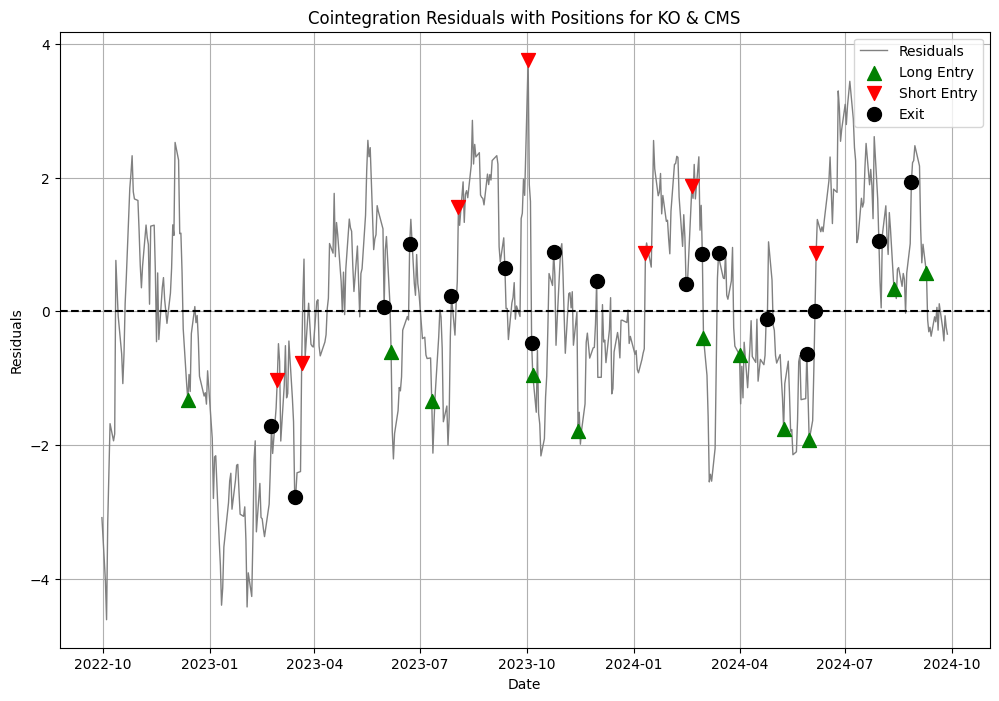

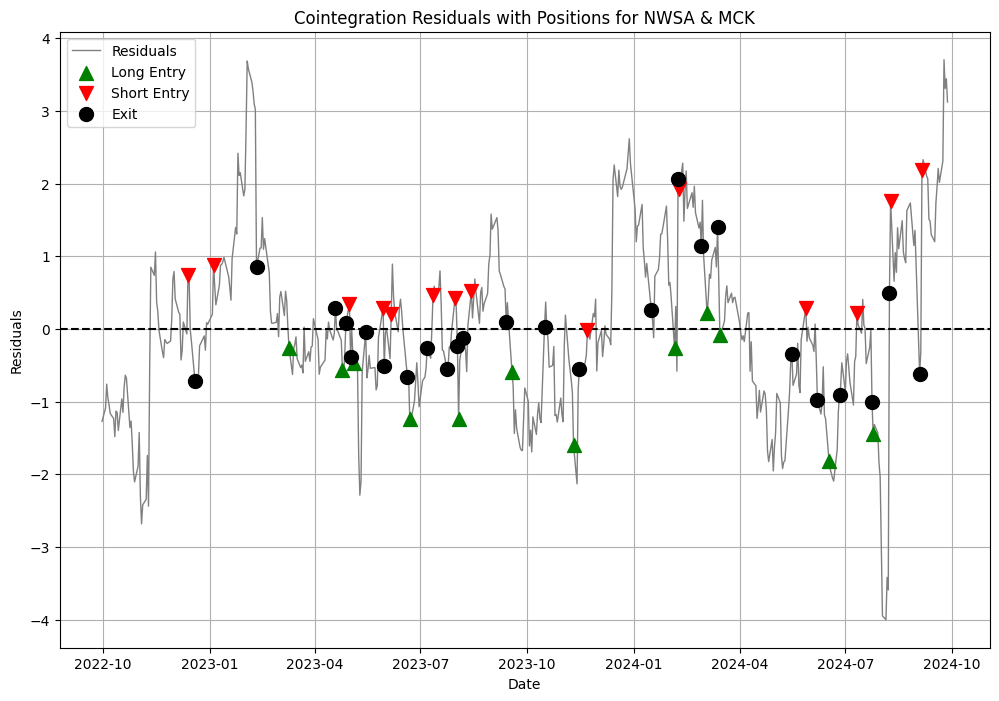

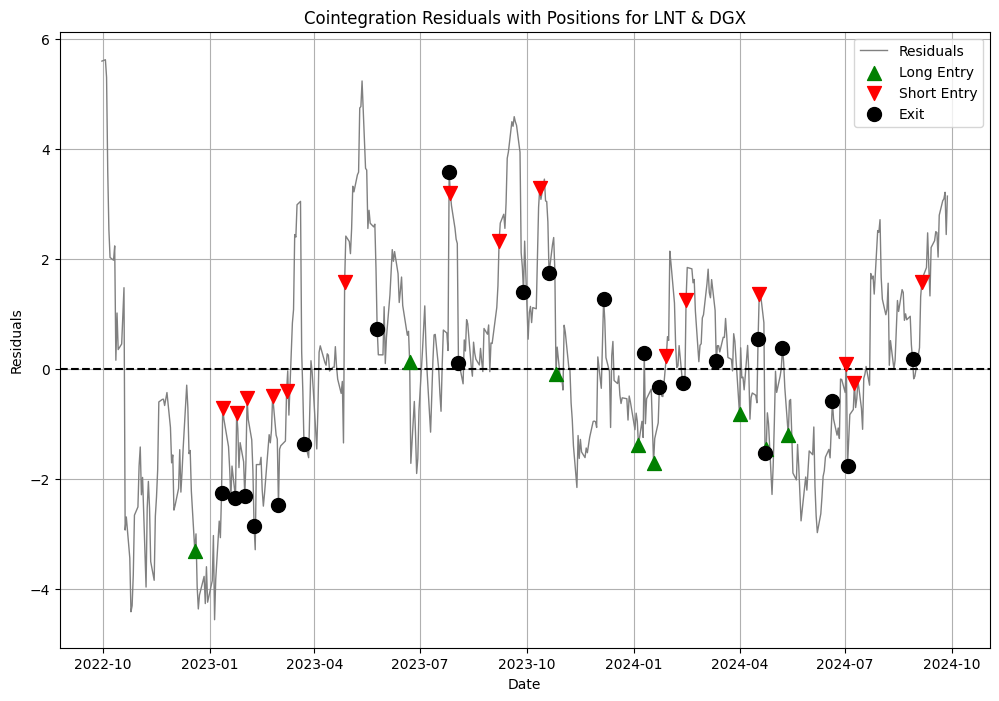

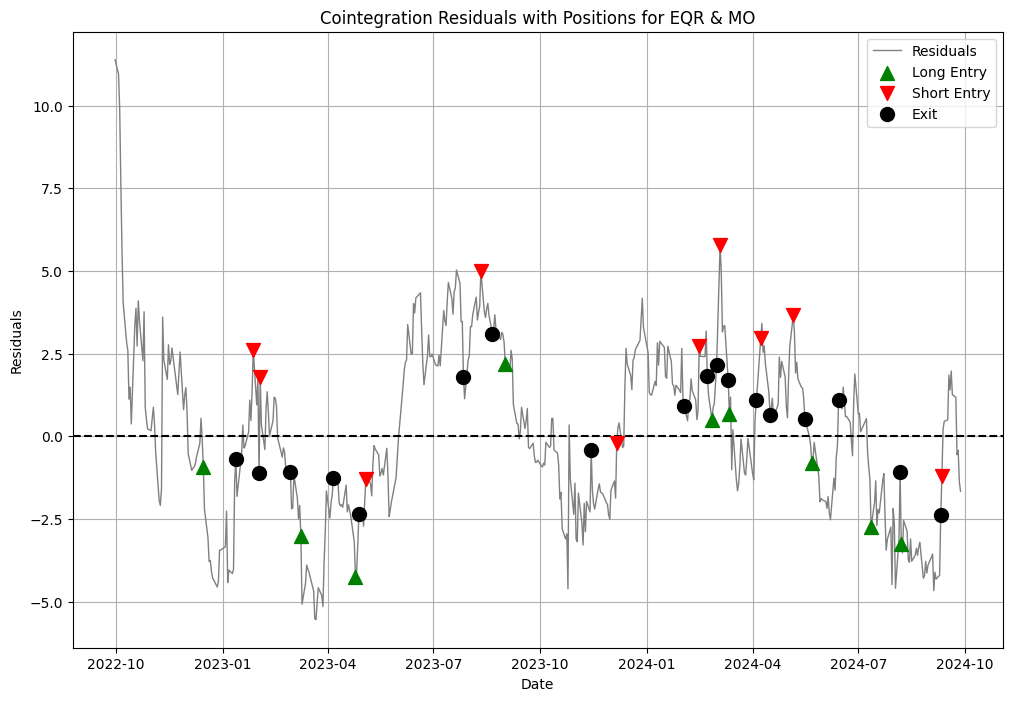

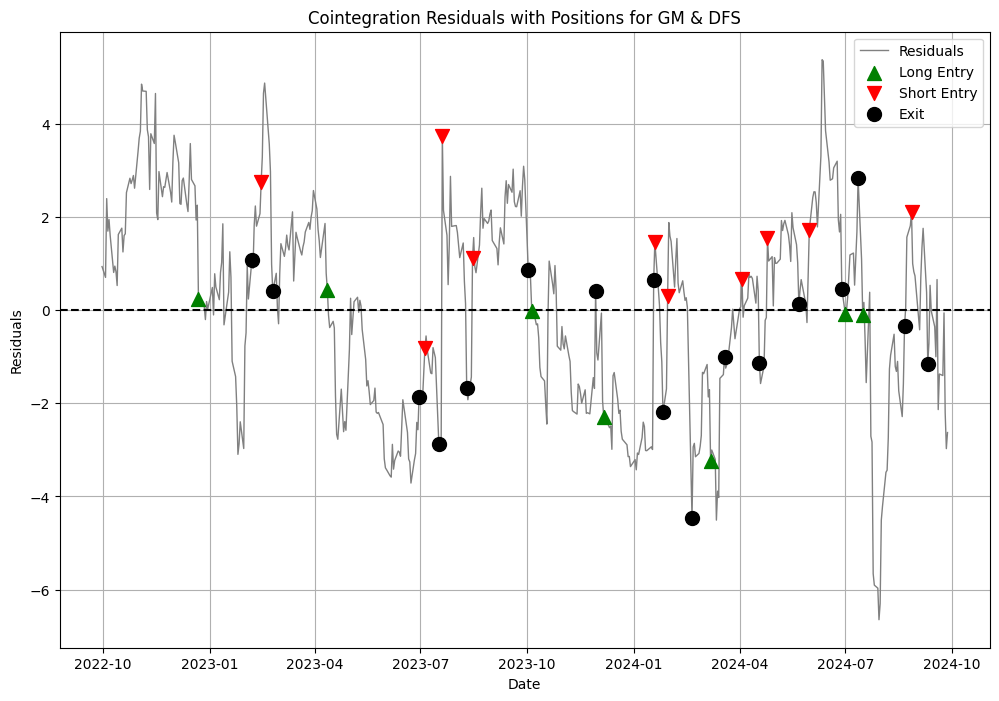

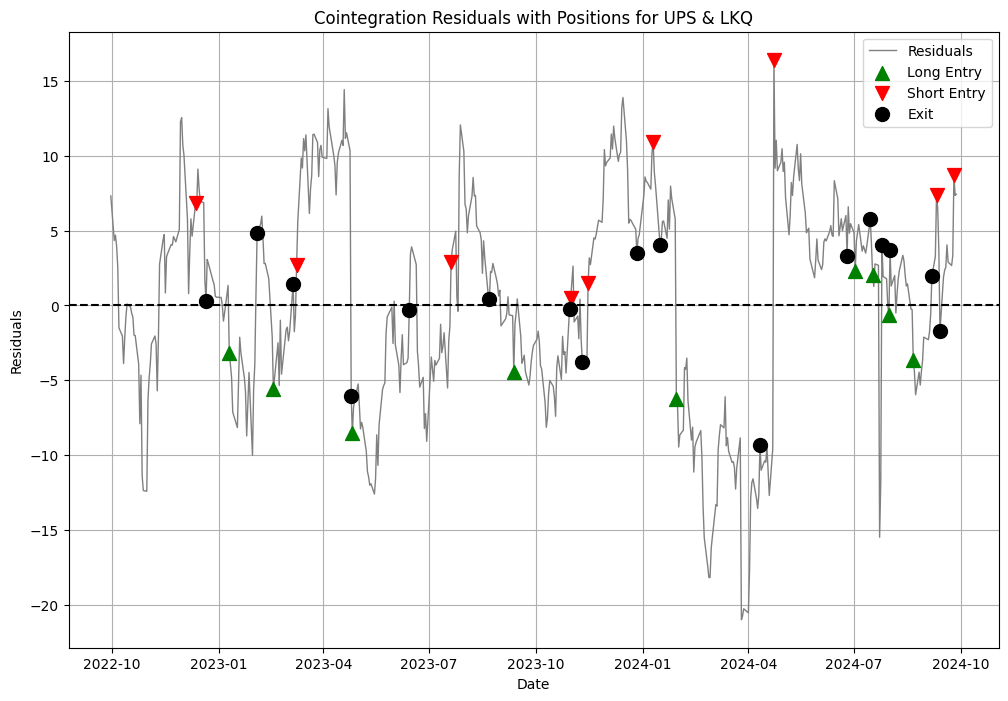

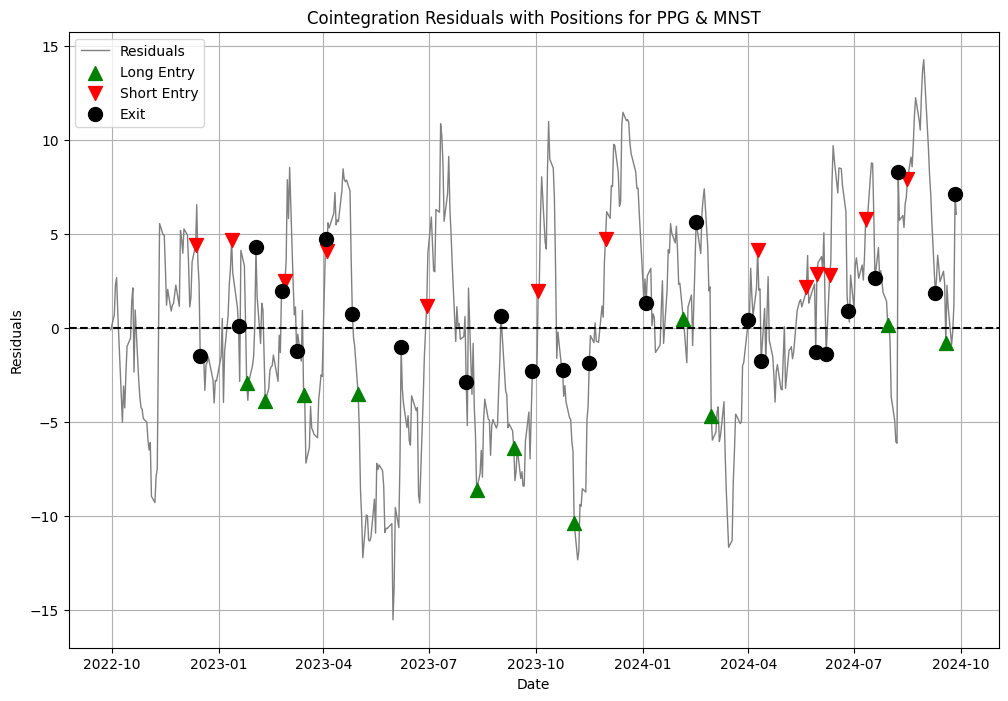

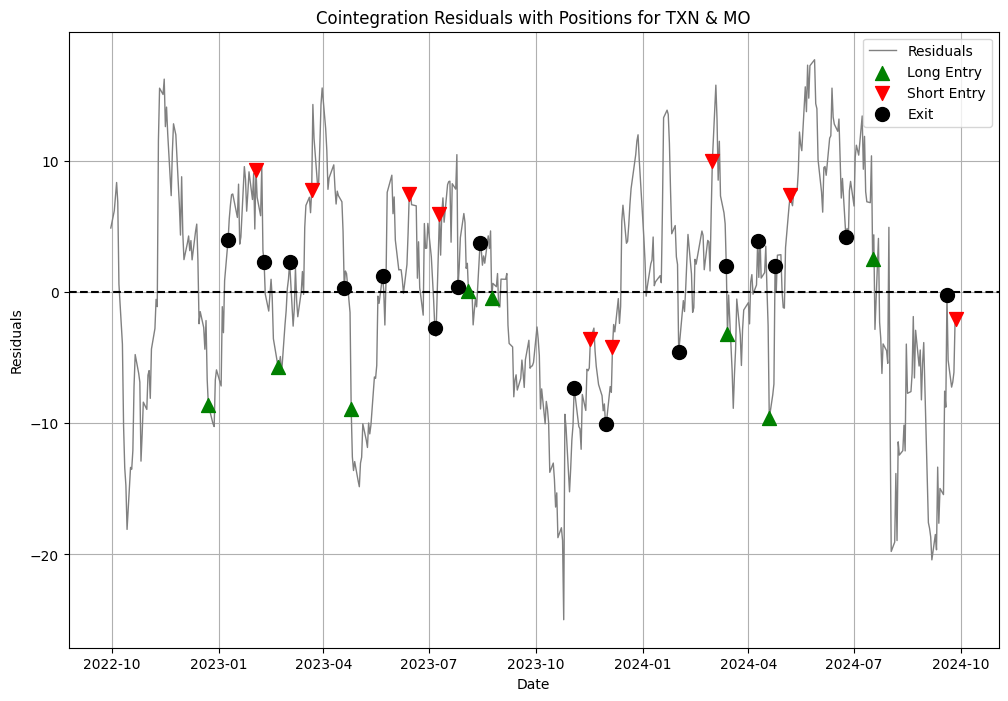

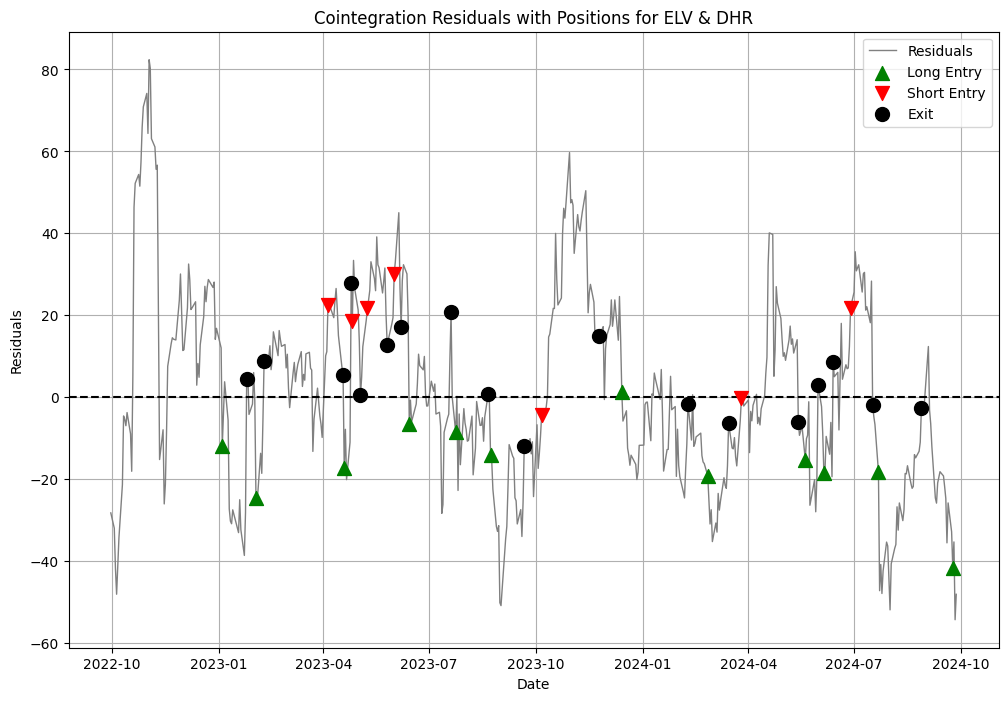

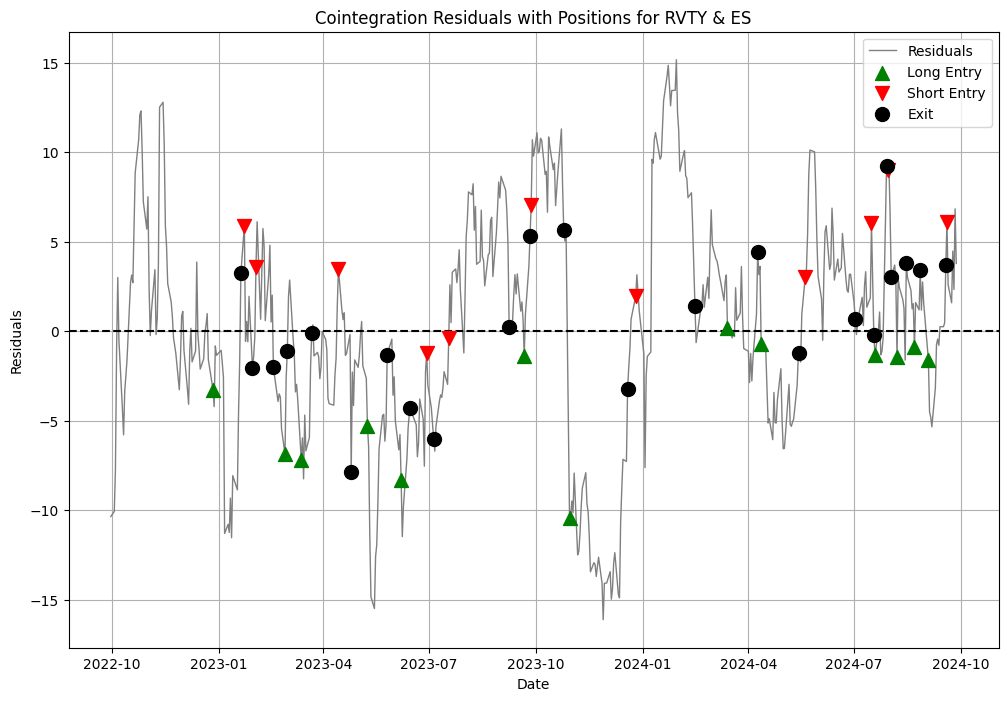

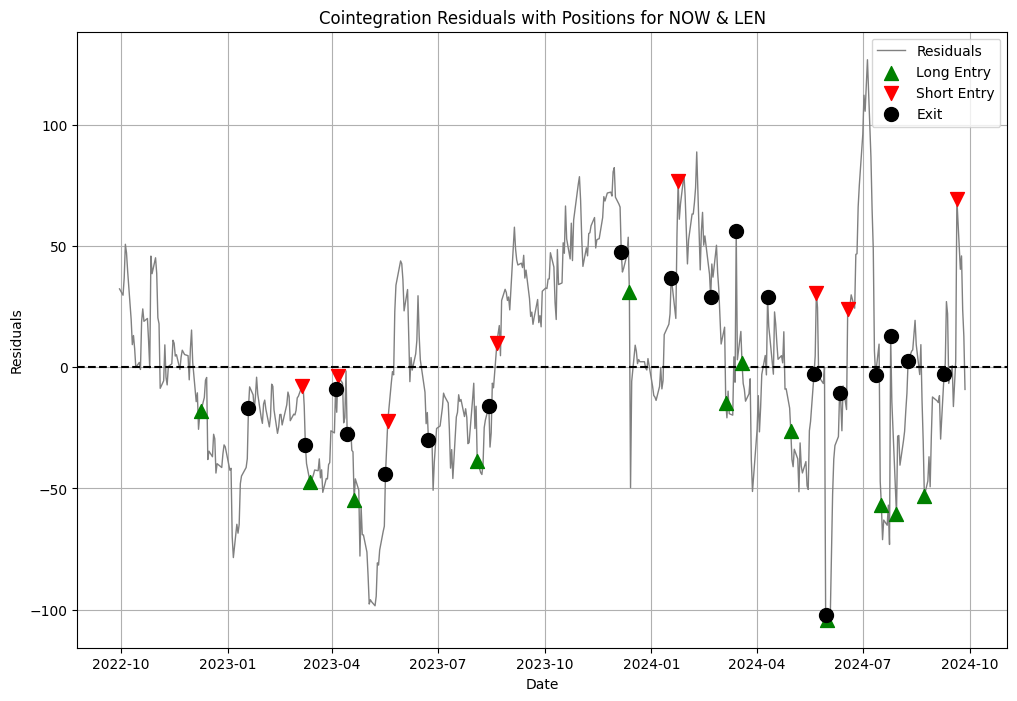

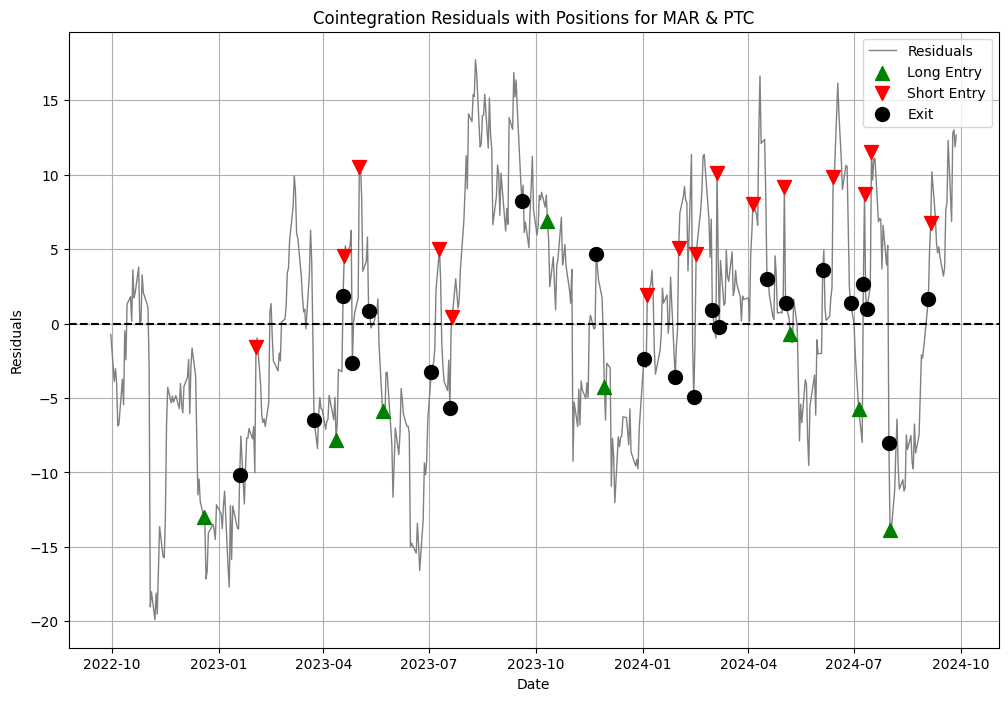

In [58]:
# Function to plot residuals with positions
def plot_residuals_with_positions(residuals, positions, stock_pair):
    plt.figure(figsize=(12, 8))
    plt.plot(residuals.index, residuals, label="Residuals", color='gray', linewidth=1)

    # Plot long, short, and exit positions
    long_positions = [i for pos, i in positions if pos == 'long']
    short_positions = [i for pos, i in positions if pos == 'short']
    exit_positions = [i for pos, i in positions if pos == 'exit']

    plt.scatter(residuals.index[long_positions], residuals.iloc[long_positions], color='green', marker='^', label='Long Entry', s=100, zorder=5)
    plt.scatter(residuals.index[short_positions], residuals.iloc[short_positions], color='red', marker='v', label='Short Entry', s=100, zorder=5)
    plt.scatter(residuals.index[exit_positions], residuals.iloc[exit_positions], color='black', marker='o', label='Exit', s=100, zorder=5)

    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"Cointegration Residuals with Positions for {stock_pair}")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(True)
    plt.show()

# Now call the plot function for the top 3 pairs
for idx, row in top_20_pairs.iterrows():
    stock1, stock2 = row['Stock 1'], row['Stock 2']
    
    # Get the residuals and positions from the backtest for each pair
    residuals = residuals_dict[(stock1, stock2)]
    positions = all_positions[(stock1, stock2)]
    
    # Plot residuals with positions for this pair
    plot_residuals_with_positions(residuals, positions, stock_pair=f"{stock1} & {stock2}")